<a href="https://colab.research.google.com/github/CherpanovNazim/learn-llm/blob/main/notebooks/04_Retrieval_augmented_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


> [GitHub Repo](https://github.com/CherpanovNazim/learn-llm)

# Setup

In [ ]:
#clone git repository
!git clone -q https://github.com/CherpanovNazim/learn-llm.git

In [ ]:
!pip install -qU \
    transformers==4.44.0 \
    sentence-transformers==3.0.1 \
    pinecone-client==4.1.2 \
    datasets==2.20.0 \
    accelerate==0.32.1 \
    einops==0.8.0 \
    langchain==0.2.13 \
    docarray==0.40.0 \
    rank_bm25==0.2.2 \
    langchain-huggingface==0.0.3 \
    langchain-openai==0.1.17 \
    fsspec==2024.5.0 \
    langchain-community==0.2.12 \
    openai==1.40.3 \
    vllm==0.5.4


# RAG (Retrieval Augmented Generation) System

**Retrieval Augmented Generation (RAG)** is a natural language processing (NLP) technique that combines the strengths of large language models (LLMs) and information retrieval (IR) systems to improve the quality of generated text.

LLMs are trained on massive datasets of text and code, and can generate text, translate languages, write different kinds of creative content, and answer your questions in an informative way. However, LLMs can be inaccurate and inconsistent, especially when asked questions about specific facts or topics.

IR systems are designed to find relevant documents in a large corpus of text. RAG systems leverage the strengths of both LLMs and IR systems to generate more accurate, informative, and diverse text.

**How RAG works**

RAG systems work in two stages:

1. **Retrieval:** The RAG system first uses an IR system to retrieve a set of relevant documents from an external knowledge base, such as Wikipedia or company-specific internal databases.
2. **Generation:** The RAG system then passes the retrieved documents to an LLM, which generates text based on the documents and the original input prompt.

The LLM can generate text in a variety of formats, including text, code, scripts, musical pieces, email, letters, etc.

**Benefits of RAG systems**

RAG systems offer a number of benefits over traditional LLM-based NLP systems:

* **Accuracy:** RAG systems are more accurate than traditional LLM-based NLP systems because they are grounded in real-world knowledge from external knowledge bases.
* **Informativeness:** RAG systems can generate more informative text than traditional LLM-based NLP systems because they have access to a wider range of information.
* **Diversity:** RAG systems can generate more diverse text than traditional LLM-based NLP systems because they are not limited by the biases of their training data.

**Applications of RAG systems**

RAG systems can be used for a variety of NLP tasks, including:

* Question answering
* Text summarization
* Creative text generation
* Code generation

**Here are some examples of how RAG systems can be used:**

* A customer service chatbot can use RAG to retrieve relevant knowledge base articles to answer customer questions more accurately and informatively.
* A news article summarization system can use RAG to retrieve relevant news articles and generate summaries that are more comprehensive and informative.
* A code generation system can use RAG to retrieve relevant code snippets and generate code that is more efficient and bug-free.

Overall, RAG systems are a powerful new tool for improving the quality and relevance of generated text.

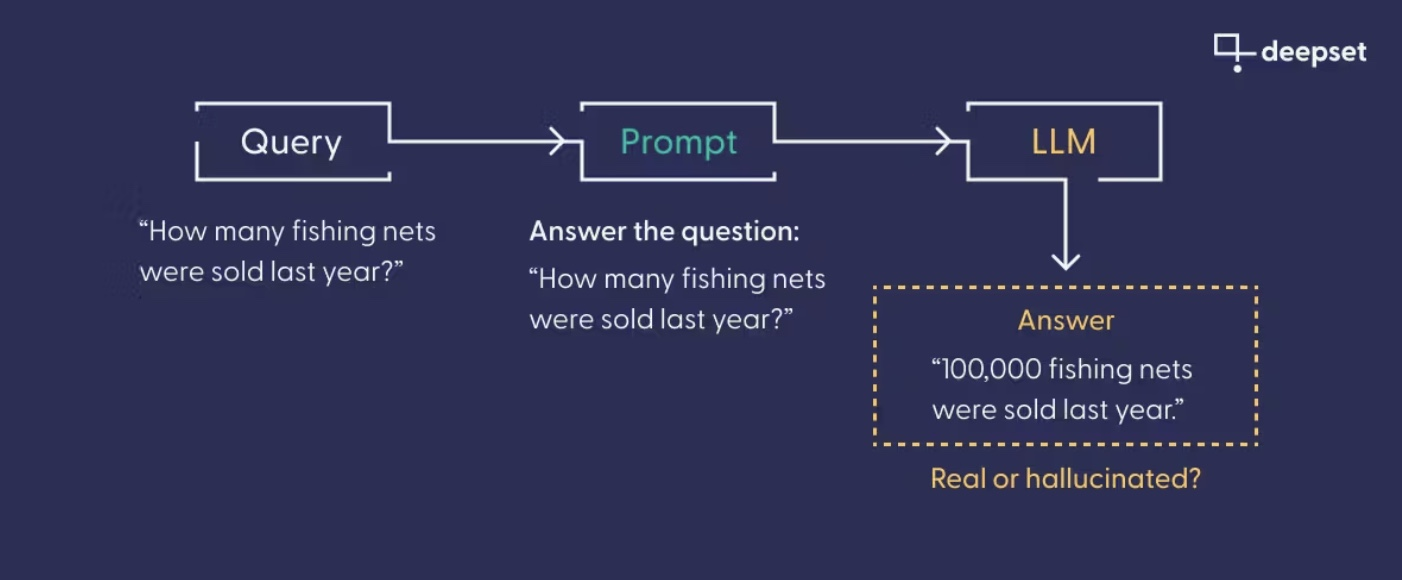

Image source: https://www.deepset.ai/blog/llms-retrieval-augmentation

# Basic Example

## Text Embedding

For text embedding we'll be using all-MiniLM-L6-v2 model from the HuggingFace that embeds texts into 384 dimensional vectors.

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

In [ ]:
# Testing embedding model
docs = [
    "first document",
    "second document"
]
embeddings = embed_model.embed_documents(docs)
print(f"There are {len(embeddings)} document embeddings, each with " f"a dimensionality of {len(embeddings[0])}.")

## Load Dataset

Dataset consists of contains chunked extracts (of ~300 tokens) from papers related to (and including) the Llama 2 research paper. More information is available at: https://huggingface.co/datasets/jamescalam/llama-2-arxiv-papers-chunked

In [ ]:
from datasets import load_dataset

data = load_dataset(
    'jamescalam/llama-2-arxiv-papers-chunked',
    split='train'
)
data

In [ ]:
import pandas as pd
# Save dataset into pandas dataframe
data = data.to_pandas()

# Inspect
data.columns

# Dropping duplicate chunks
data = data.drop_duplicates(subset=['chunk'])
data.shape

## Create Local Vector Database

We need Document type data structure that stores not only text that our model will work on but metadata as well

In [ ]:
from langchain.schema.document import Document

def example_to_document(example: dict) -> Document:
    return Document(
        page_content=str(example["chunk"]),
        metadata={
            "chunk-id": str(example["chunk-id"]),
            "id": str(example['id']),
            "title": str(example["title"]),
            "summary": str(example["summary"]),
        },
    )

For storing embeddings and associate metadata we'll be using DocArrayInMemorySearch based on Docarray module that creates in memory database. It's usefull for demonstration purposes and small datasets. For large datasets specialized vector DBs are recommended with built-in specialized algorithms for fast and efficient search and retrieval.

In [ ]:
# Converting each text chunk to Document type structure
docs = [example_to_document(example) for example in data[['chunk', 'chunk-id','id', 'title', 'summary']].to_dict(orient='records')]

In [ ]:
from langchain.vectorstores import DocArrayInMemorySearch

# Create database of embeddings
db = DocArrayInMemorySearch.from_documents(docs, embed_model)

## Retriever Component

A retriever in a RAG system is an algorithm that searches a large corpus of text and retrieves the most relevant passages for a given query.

It is essential for providing the LLM generator with the necessary context to generate a high-quality response. Without the retriever, the generator would have to rely solely on its own internal knowledge, which would limit its ability to generate accurate and informative responses.

In [ ]:
# Let's test the LLAMA model with a query that could be confused with an animal
query = "what is so special about llama 2?"

In [ ]:
# search for the top 5 contextually most similar chunks of texts
res = db.similarity_search_with_score(query, k = 5)
res

## Testing LLama 3 Model without RAG

Now test the model for the defined query without providing any context.

In [ ]:
# wait ~3 min for installations
%%time

import json
import sys

# Load the default model
DEFAULT_MODEL = json.load(open('learn-llm/configs/llama_3_8B_instruct_awq.json', 'r'))

# #run VLLM
!nohup vllm serve {DEFAULT_MODEL['model']} --quantization awq --max-model-len=4096 > vllm.log &
!tail -f vllm.log | grep -q "Uvicorn running" && echo "Now you can start using the model"

In [ ]:
# Initialize LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model = DEFAULT_MODEL["model"],
    openai_api_base=DEFAULT_MODEL['api_base'],
    openai_api_key=DEFAULT_MODEL['api_key'],
    frequency_penalty=0.5,  # Reduces repetition
    presence_penalty=0,  # Avoids introducing new ideas
    )

In [ ]:
llm_output = llm.invoke(query)
print(llm_output.content)

## Testing LLAMA 3 Model with RAG

In the wider scope of the LLAMA 3 model, word-number combination of llama+2 most likely refers to the animal. Let's try the same query
with RAG pipeline to shrink the context space.

In [ ]:
from langchain.chains import RetrievalQA

# Define retriever
retriever = db.as_retriever(search_type='similarity', search_kwargs={'k': 5})
# Define RAG chain
qa_chain = RetrievalQA.from_chain_type(llm,retriever=retriever, chain_type='stuff')
response=qa_chain.invoke({"query": query})
rag_output = response['result']

# Pretty-print the output
rag_lines = rag_output.split('\n')
for line in rag_lines:
    print(line)

# More Advanced Example

Previously, the text that we used for our first RAG application, was already chunked/splitted in approximately 300 tokens-sized pieces, however in real-life scenarios, text is given in a raw, unprocessed format and the chunking stage is one of the crucial steps in developing effective RAG application.


In RAG applications, the retriever module is responsible for finding relevant passages from a large corpus of text to provide context for the generative language model (LLM). The LLM then uses this context to generate text, translate languages, or answer questions in a comprehensive and informative way.

Therefore the text chunking is important for RAG applications for several reasons:

* **Efficiency:** Chunking the input text allows the retriever to more efficiently identify relevant passages.
* **Accuracy:** Chunking can also improve the accuracy of the retriever by allowing it to focus on smaller, more coherent, specific units of text.
* **Control:** Chunking gives the developer more control over the retrieval process. For example, the developer can specify the maximum chunk size or the type of chunks to be retrieved (e.g., sentences, paragraphs, etc.).
* **Context Limitation:** LLM models usualy have finite context window, therefore it's necessary to provide only essential, contextually relevant information to fit into this limitation.


There are a number of different methods for text chunking. Some common methods include:

* **Sentence boundary detection:** This method splits the text into sentences based on punctuation and other syntactic cues.
* **Paragraph boundary detection:** This method splits the text into paragraphs based on indentation, blank lines, and other formatting cues.
* **Topic segmentation:** This method splits the text into segments that are topically coherent. This can be done using a variety of techniques, such as latent Dirichlet allocation (LDA) or topic modeling.


The best chunking method for a particular RAG application will depend on the specific needs of the application. For example, if the goal is to improve the efficiency of the retriever, then a simple sentence or paragraph boundary detection method may be sufficient. However, if the goal is to improve the accuracy of the retriever or to provide more control over the retrieval process, then a more sophisticated topic or discourse segmentation method may be necessary.

## Loading LLama-2 Related Papers
Dataset is available at: https://huggingface.co/datasets/jamescalam/llama-2-arxiv-papers

In [ ]:
data_raw = load_dataset(
    'jamescalam/llama-2-arxiv-papers',
    split='train'
)
data_raw

In [ ]:
# Convert dataset into pandas dataframe
data_raw = data_raw.to_pandas()

# Inspect
data_raw.shape, data_raw.columns

In [ ]:
data_raw.head(2)

## Text Chunking

For the demonstration purposes we'll be using **RecursiveCharacterTextSplitter** chunking that results in chunks with the same amount of tokens while doesn't require third-party NLP libraries or models.

The **RecursiveCharacterTextSplitter** divides a given text based on a given chunk size using specific characters. By default, it uses **["\n\n", "\n", " ", ""]**. The process starts by attempting to split the text using the first character, **"\n\n"**. If the resulting split remains too big, it proceeds to the next character, **"\n"**, and so on, until the output is smaller than the **predetermined chunk size**.

In [ ]:
# Define text splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Splitting parameters
chunk_size = 512
chunk_overlap = 25

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
)

# New dataframe generation
def create_chunked_dataframe(df):

    # store intermdiate results
    new_rows = []

    for _, row in df.iterrows():
        paper_id = row['id']
        chunks = text_splitter.create_documents([row['content']]) #it's necessary to put text into list as RecursiveCharacterTextSplitter expects

        for chunk in chunks:
            new_rows.append({'id': paper_id, 'text': chunk})

    # construct new df
    new_df = pd.DataFrame(new_rows)

    return new_df

In [ ]:
# Create chunks
chunk_df = create_chunked_dataframe(data_raw)

# Dropping duplicate chunks
chunk_df = chunk_df.drop_duplicates(subset=['text'])
chunk_df.shape

In [ ]:
chunk_df.head()

## Retrieval

In the basic example **all-MiniLM-L6-v2** model for chunk embeddings that was a crucial step for retrieving chunks contextually most relevant to a given prompt query. For the demonstration purposes, now we'll be using BM25 algorithm that doesn't require any LLM or NLP models and that was developed in early 70s as a probabilistic retrieval algorithm for information search systems.

In [ ]:
from langchain.retrievers import BM25Retriever

# k=10 implies that our RAG system with generate response based on the top 10 most relevant chunks of texts
bm25_retriever = BM25Retriever.from_documents(chunk_df['text'], k=10)

In [ ]:
result = bm25_retriever.invoke(query)
result

## BM25 Based RAG System

As we already have defined LLM model and retriever, we can construct basic RAG system in the same way as before with Langchain.

# THIS DOES NOT PROVIDE CORRECT OUPUT

As seen in old notebook, retriever returns same documents, but RetrievalQA chain does not detect relevant results.
Below is modified chain, that returns correct output using BM25 as a retriever

TODO: decide what chain to keep

In [ ]:
# Define RAG chain
bm25_chain = RetrievalQA.from_chain_type(llm, retriever=bm25_retriever, chain_type='stuff')
bm25_response=bm25_chain({"query": query})
bm25_rag_output = bm25_response['result']

# The output
print(bm25_rag_output)

In [ ]:
!pip install langchainhub==0.1.20

In [ ]:
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate


prompt = ChatPromptTemplate.from_messages([
  ("system", "Answer any use questions based solely on the context below: <context> {context} </context>"),
  ("placeholder", "{chat_history}"),
  ("human", "{input}"),
])

retrieval_qa_chat_prompt = prompt
combine_docs_chain = create_stuff_documents_chain(
    llm, retrieval_qa_chat_prompt
)
retrieval_chain = create_retrieval_chain(retriever, combine_docs_chain)

result = retrieval_chain.invoke({"input":query})
print(result['answer'])

# Homework

BM25 Retriever generated acceptable results after trying different parameters for **RecursiveCharacterTextSplitter** component. There're lot of ways to improve current RAG system, including:
- Changing splitting method (and it parameters);
- Use different embedding model from open-source HuggingFace Model Zoo;
- Use different retrieval method;

Your task is to use:
- Refer to langchain documentation on text splitters and choose try another chunking method:
  https://api.python.langchain.com/en/latest/api_reference.html#module-langchain.text_splitter
(for example, NLTKTextSplitter might result in better context preservation)
- Use different type of retriever method implement in Langchain: https://python.langchain.com/docs/modules/data_connection/retrievers/